In [16]:
import re
import os
from tqdm.auto import tqdm
from sentence_transformers import evaluation
import torch 
from transformers import BertModel
from transformers import BertTokenizer
from datasets import Dataset
import pandas as pd
from transformers.optimization import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt 
import numpy as np
import sklearn.model_selection
import sklearn
from sentence_transformers import SentenceTransformer, InputExample, losses, util

In [17]:
#load data 
df = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTrainData.csv", sep="\t")
df = df.loc[(df["url1_lang"] == "en") & (df["url2_lang"] == "en")]

#put ground truth values into a list 
df["ground_truth"] = df['Overall']


Text(0, 0.5, 'count')

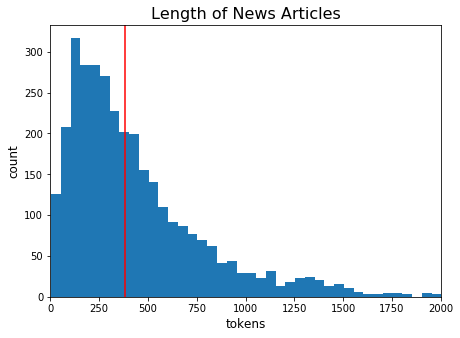

In [18]:
fig, axs = plt.subplots(figsize=[7, 5])
len1 = list(df.dropna()["text1"].apply(lambda x: len(x.split())))
len2 = list(df.dropna()["text2"].apply(lambda x: len(x.split())))
plt.hist(len1 + len2, bins=200)
plt.axvline(384, color="red")
plt.xlim([0, 2000])
plt.title("Length of News Articles", size=16)
plt.xlabel("tokens", size=12)
plt.ylabel("count", size=12)

4.0

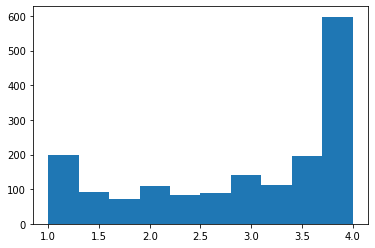

In [19]:
plt.hist(df["ground_truth"])
min(df["ground_truth"])
max(df["ground_truth"])

In [20]:

#TODO: do we need to make data tensors or does this happen when we call set_format() later on
#df["ground_truth"] = df["ground_truth"].apply(torch.tensor)

#[torch.tensor(gtList) for gtList in df["ground_truth"]]

#get only the columns we need 
#TODO: do we need "pair_id"? 
leanDf = df[["ground_truth",  'text1', 'text2']].dropna()
print(min(leanDf["ground_truth"]))
#rescale data from (0, 4): (0, 1)
leanDf["ground_truth"] = 1 - ((leanDf["ground_truth"] - 1) / 3)


1.0


(array([593., 189., 113., 139.,  75.,  98., 110.,  71.,  91., 197.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

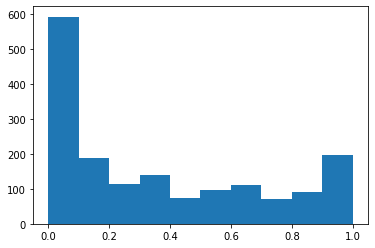

In [21]:
plt.hist(leanDf["ground_truth"])

In [22]:
max(leanDf["ground_truth"])

1.0

In [23]:
deviceNum = 4
def check_mem():
    torch.cuda.empty_cache()
    a = torch.cuda.memory_allocated(deviceNum)/1024/1024/1024
    r = torch.cuda.memory_reserved(deviceNum)/1024/1024/1024
    print("torch.cuda.memory_allocated: %fGB"%a)
    print("torch.cuda.memory_reserved: %fGB"%r)
    print("torch.cuda.memory_free: %fGB"%(r-a))
    print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(deviceNum)/1024/1024/1024))
check_mem()

#split data 
trainDf, validDf = sklearn.model_selection.train_test_split(leanDf, train_size=.75, test_size=.25)
trainDf = trainDf.reset_index(drop=True)
trainDf.head(2)

print("Train Rows: " + str(trainDf.shape[0]))
print("Validation Rows: "  + str(validDf.shape[0]))

torch.cuda.memory_allocated: 0.818541GB
torch.cuda.memory_reserved: 1.117188GB
torch.cuda.memory_free: 0.298646GB
torch.cuda.max_memory_reserved: 8.830078GB
Train Rows: 1257
Validation Rows: 419


In [24]:
#TODO: figure out how to keep punctuation after splitting 
#TODO: also it seems broken... 
MAX_LEN = 384
def splitText(inStr): 
    #matches combinations of punctuation of any length (e.g. !??..??! would match)
    #sents = re.split("[.!?]+", inStr)
    sents = re.findall(".*?[.!?]+", inStr)
    trainExamples = []
    chunkIter = 0
    currLen = 0 
    currText = ""
    #print(sents)
    while chunkIter < len(sents): 
        
        #Add the chunk/sentence to the current training example we are making 
        #current chunk/sentence we want to add 
        currChunk = sents[chunkIter]
        #print("------------------------------")
        #print(currChunk)
        #check how long our string would be if we added this chunk 
        potLen = currLen + len(currChunk.split())
        #print(potLen)
        if potLen < MAX_LEN: 
            #print("less than")
            #add the sentance to the current string (training example)
            #print("added " + currChunk + " to " + currText)
            currText += currChunk
            
        else: 
            #add the current training string to the list of train examples and then set
            #it to an empty string again 
            #print(str(potLen) + " > " + str(MAX_LEN))
            trainExamples.append(currText)
            currText = currChunk
            
        #get the current length of our training example 
        currLen = len(currText.split())
        
        #always want to move to the next chunk 
        chunkIter += 1
    
    #the last portion won't get added so we add it here 
    trainExamples.append(currText)
    #print(trainExamples)
    return trainExamples 

testExample = "Hello everyone!!!? How's it going? Yep... Here we are.? "
print(splitText(testExample))

["Hello everyone!!!? How's it going? Yep... Here we are.?"]


In [29]:
trainProp = len(trainDf) / (len(trainDf) + len(validDf))
print("Train Proportion: " + str(trainProp))
print("Validation Proportion: " + str(1 - trainProp))

Train Proportion: 0.75
Validation Proportion: 0.25


In [27]:
trainExamples = []
for row in trainDf.itertuples(): 
    trainExamples.append(InputExample(texts =[row[2], row[3]], label=row[1]))

In [28]:
len(trainExamples)

1257

In [43]:
#fit model!
torch.cuda.empty_cache()

#del model
#os.rmdir("/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/output")
#os.rmdir("/home/blitt/projects/localNews/models/sentEmbeddings/0.1-mpNetCosSimChunked/checkpoint")
check_mem()

model = SentenceTransformer('all-mpnet-base-v2', device="cuda:" + str(deviceNum))

#Define your train examples. You need more than just two examples...
#train_examples = [InputExample(texts=['My first sentence', 'My second sentence'], label=0.8),
#    InputExample(texts=['Another pair', 'Unrelated sentence'], label=0.3)]

#Define your train dataset, the dataloader and the train loss
train_dataloader = torch.utils.data.DataLoader(trainExamples, shuffle=True, batch_size=8)

#works OK 
#train_loss = losses.MultipleNegativesRankingLoss(model)

train_loss = losses.CosineSimilarityLoss(model)

evaluator = evaluation.EmbeddingSimilarityEvaluator(list(validDf["text1"]), list(validDf["text2"]), list(validDf["ground_truth"]))

check_mem()

#Tune the model
#"/shared/3/projects/benlitterer/localNews/NetworkMVP/SBERTstockEval"
output_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.2-mpNetCosSimTestChunked/output"
checkpoint_path = "/home/blitt/projects/localNews/models/sentEmbeddings/0.2-mpNetCosSimTestChunked/checkpoint"
evaluation_steps = 75
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=3, warmup_steps=75, evaluator=evaluator, evaluation_steps = evaluation_steps, output_path=output_path, checkpoint_path=checkpoint_path, save_best_model=True)

torch.cuda.memory_allocated: 0.818541GB
torch.cuda.memory_reserved: 1.097656GB
torch.cuda.memory_free: 0.279115GB
torch.cuda.max_memory_reserved: 8.853516GB
torch.cuda.memory_allocated: 0.000000GB
torch.cuda.memory_reserved: 0.000000GB
torch.cuda.memory_free: 0.000000GB
torch.cuda.max_memory_reserved: 8.853516GB


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/158 [00:00<?, ?it/s]

Iteration:   0%|          | 0/158 [00:00<?, ?it/s]

In [44]:
evalData = pd.read_csv("/home/blitt/projects/localNews/models/sentEmbeddings/0.2-mpNetCosSimTestChunked/output/eval/similarity_evaluation_results.csv")

In [45]:
evalData

,epoch,steps,cosine_pearson,cosine_spearman,euclidean_pearson,euclidean_spearman,manhattan_pearson,manhattan_spearman,dot_pearson,dot_spearman
0,0,75,0.818863,0.790326,0.824899,0.790326,0.825001,0.792229,0.818863,0.790326
1,0,150,0.825083,0.797066,0.826419,0.797066,0.826286,0.798358,0.825083,0.797066
2,0,-1,0.826080,0.795720,0.826176,0.795720,0.826049,0.796601,0.826080,0.795720
3,1,75,0.832909,0.808583,0.835007,0.808583,0.833939,0.806146,0.832909,0.808583
4,1,150,0.836758,0.809214,0.837282,0.809214,0.836189,0.806550,0.836758,0.809214
5,1,-1,0.837015,0.809509,0.838517,0.809509,0.837397,0.807822,0.837015,0.809509
6,2,75,0.836433,0.807676,0.836784,0.807676,0.835259,0.805151,0.836433,0.807676
7,2,150,0.836598,0.807459,0.836543,0.807459,0.834660,0.803564,0.836598,0.807459
8,2,-1,0.836599,0.807406,0.836557,0.807406,0.834676,0.803563,0.836599,0.807406


In [46]:
#TODO: change output path so we don't get this. Create whole new folder for this model..? 

<ipython-input-47-5dbc6464e0a6>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plotData["totalSteps"] = totalSteps


Text(0, 0.5, 'Pearson Correlation')

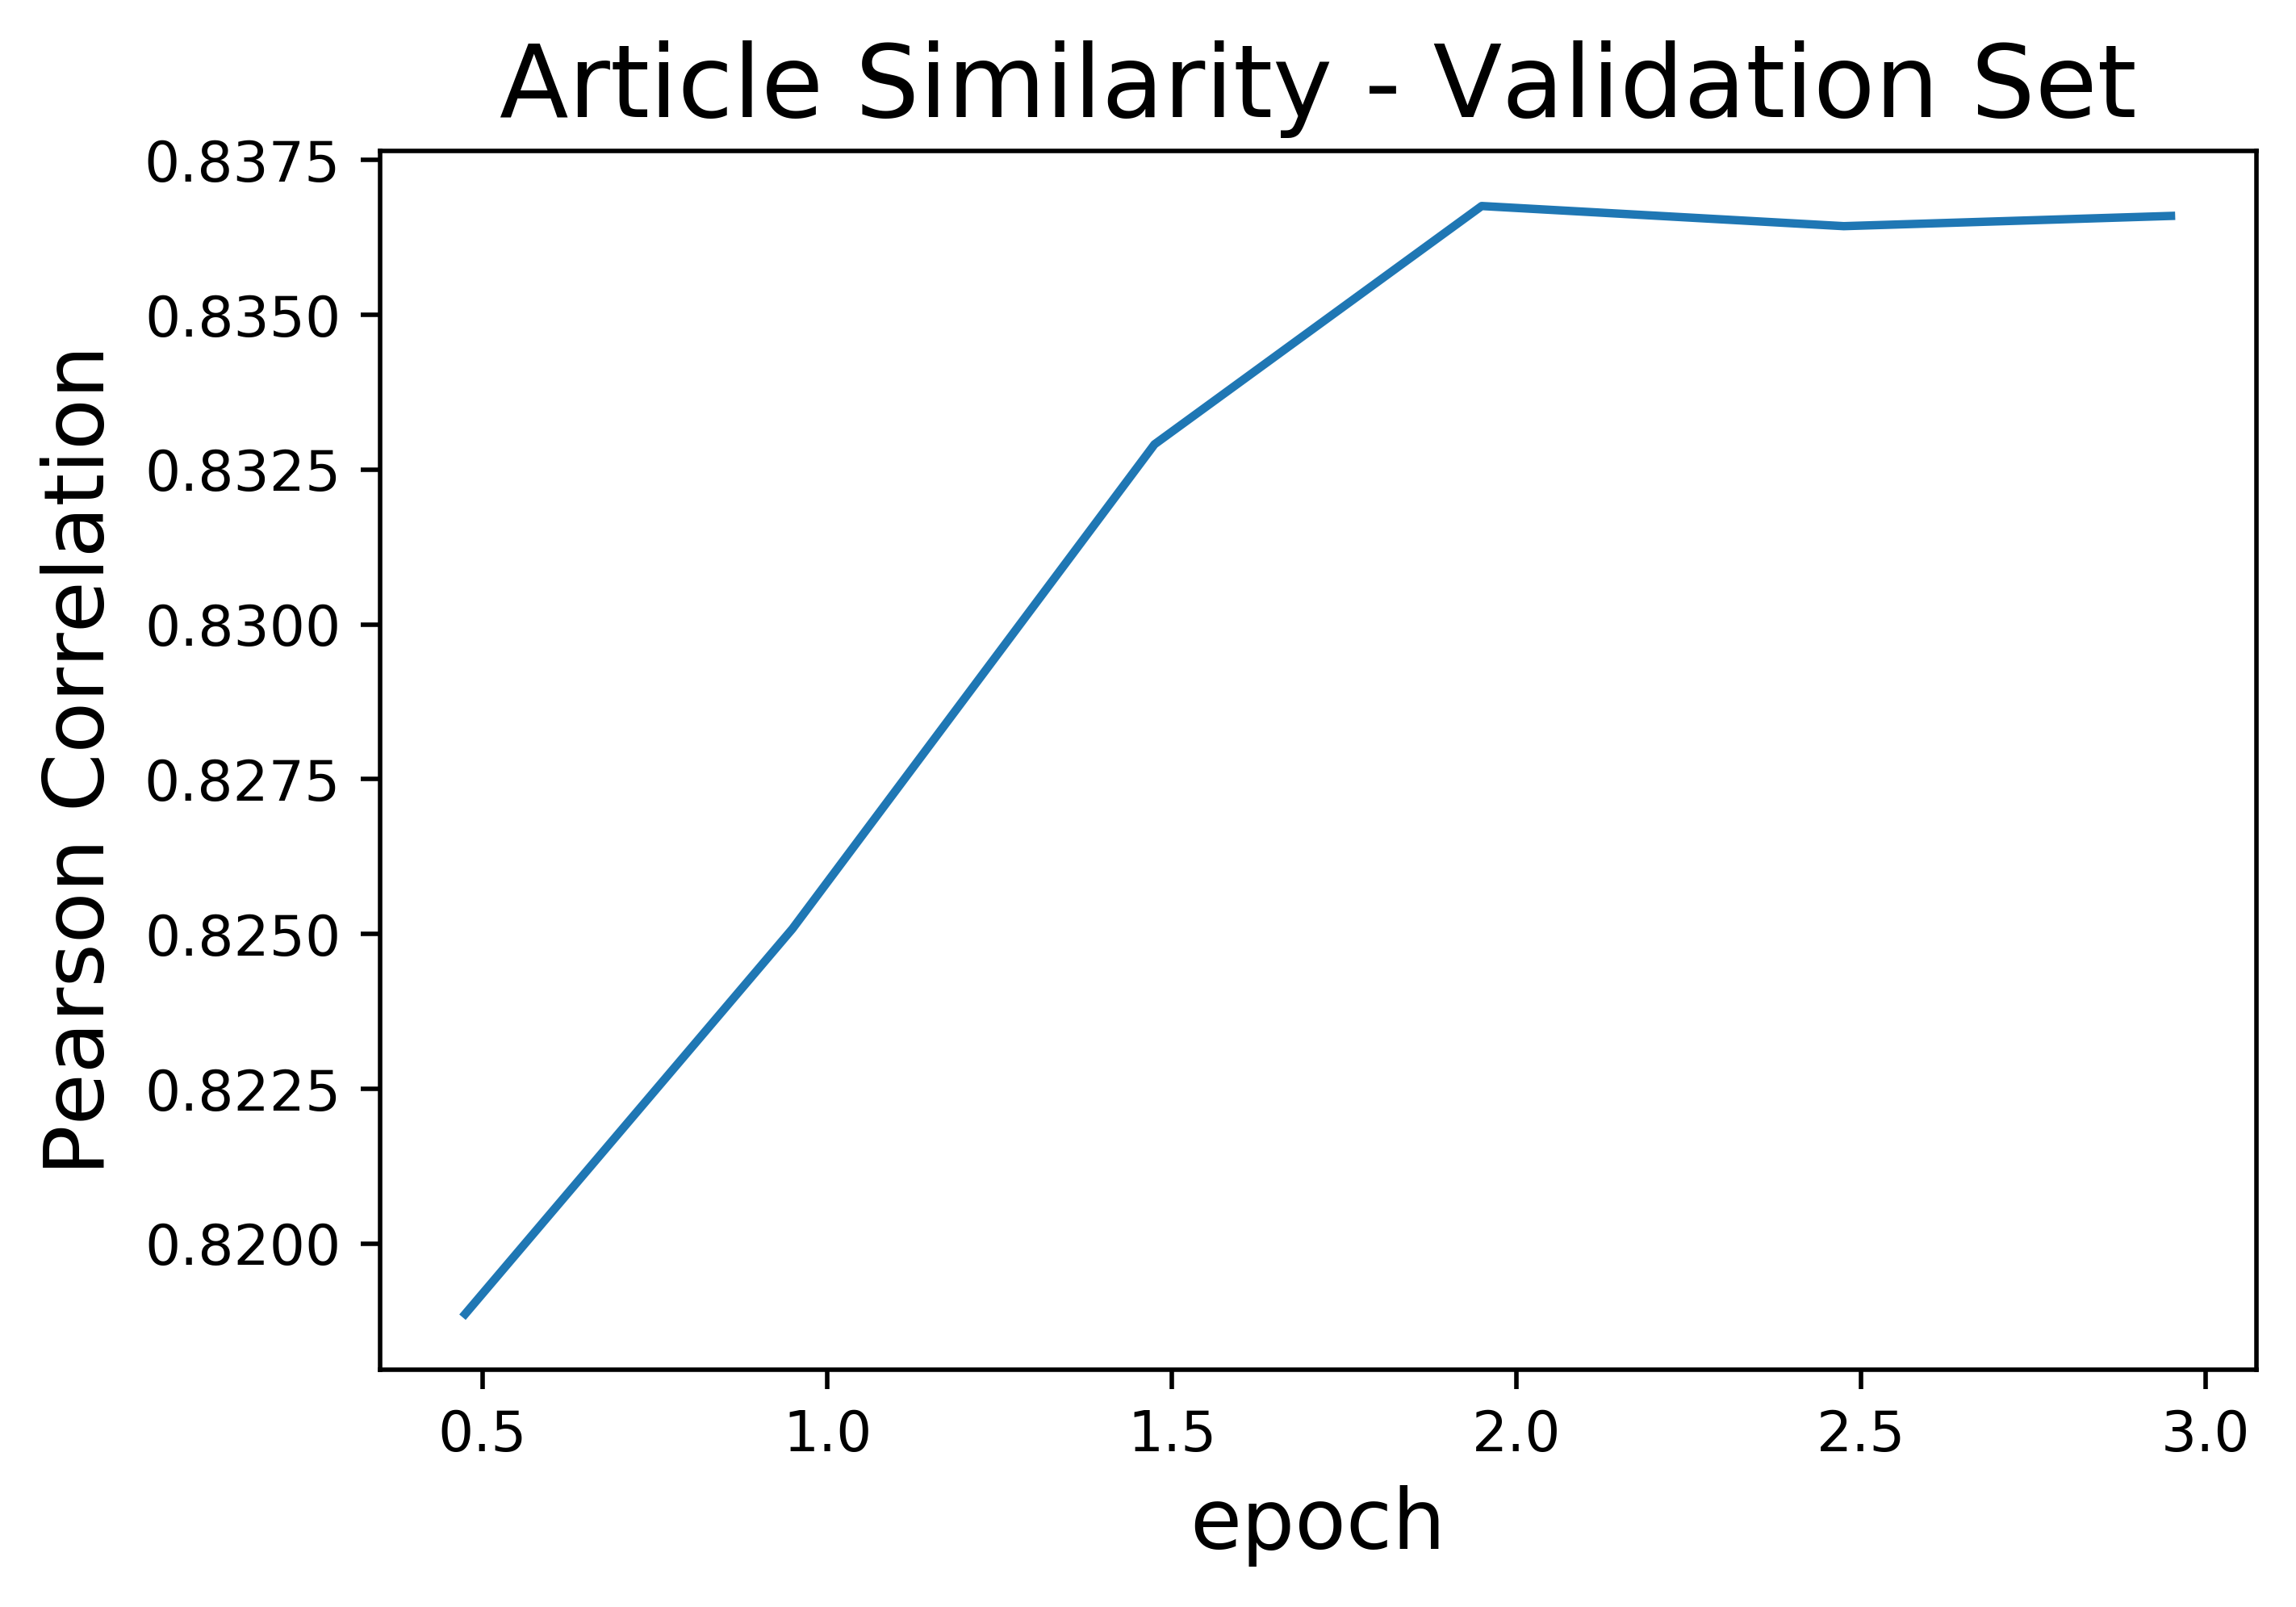

In [47]:
EPOCH_SIZE = 158
EVALUATION_STEPS = evaluation_steps 

#format the data in dataframe 
plotData = evalData[evalData["steps"] != -1]
currStep = 0 
totalSteps = (plotData["steps"] / EPOCH_SIZE) + plotData["epoch"]

    
plotData["totalSteps"] = totalSteps

#plot eval 
plt.rcParams['figure.dpi'] = 500
plt.plot(plotData["totalSteps"], plotData["cosine_pearson"])
plt.title("Article Similarity - Validation Set", size=18)
plt.xlabel("epoch", size=15)
plt.ylabel("Pearson Correlation", size=15)

In [49]:
#get test data 
#testRow = validDf.reset_index(drop=True).iloc[0,:]
#testExample = InputExample(texts = [testRow[1], testRow[2]], label=testRow[0])
testDf = pd.read_csv("/shared/3/projects/benlitterer/localNews/NetworkMVP/enTestData.csv", sep="\t")
testDf.head(1)
print(testDf.shape)

(234, 19)


In [50]:
#chunk our test data 
testChunked = testDf[["text1", "text2", "Overall"]]
testChunked["text1"] = testChunked["text1"].apply(splitText)
testChunked = testChunked.explode(column="text1")
testChunked["text2"] = testChunked["text2"].apply(splitText)
testChunked = testChunked.explode(column="text2")

<ipython-input-50-349540b66543>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testChunked["text1"] = testChunked["text1"].apply(splitText)


In [51]:
testChunked["len1"] = testChunked["text1"].apply(lambda x: len(x.split()))
testChunked["len2"] = testChunked["text2"].apply(lambda x: len(x.split()))


In [52]:
testDf["len1"] = testDf["text1"].apply(lambda x: len(x.split()))
testDf["len2"] = testDf["text2"].apply(lambda x: len(x.split()))


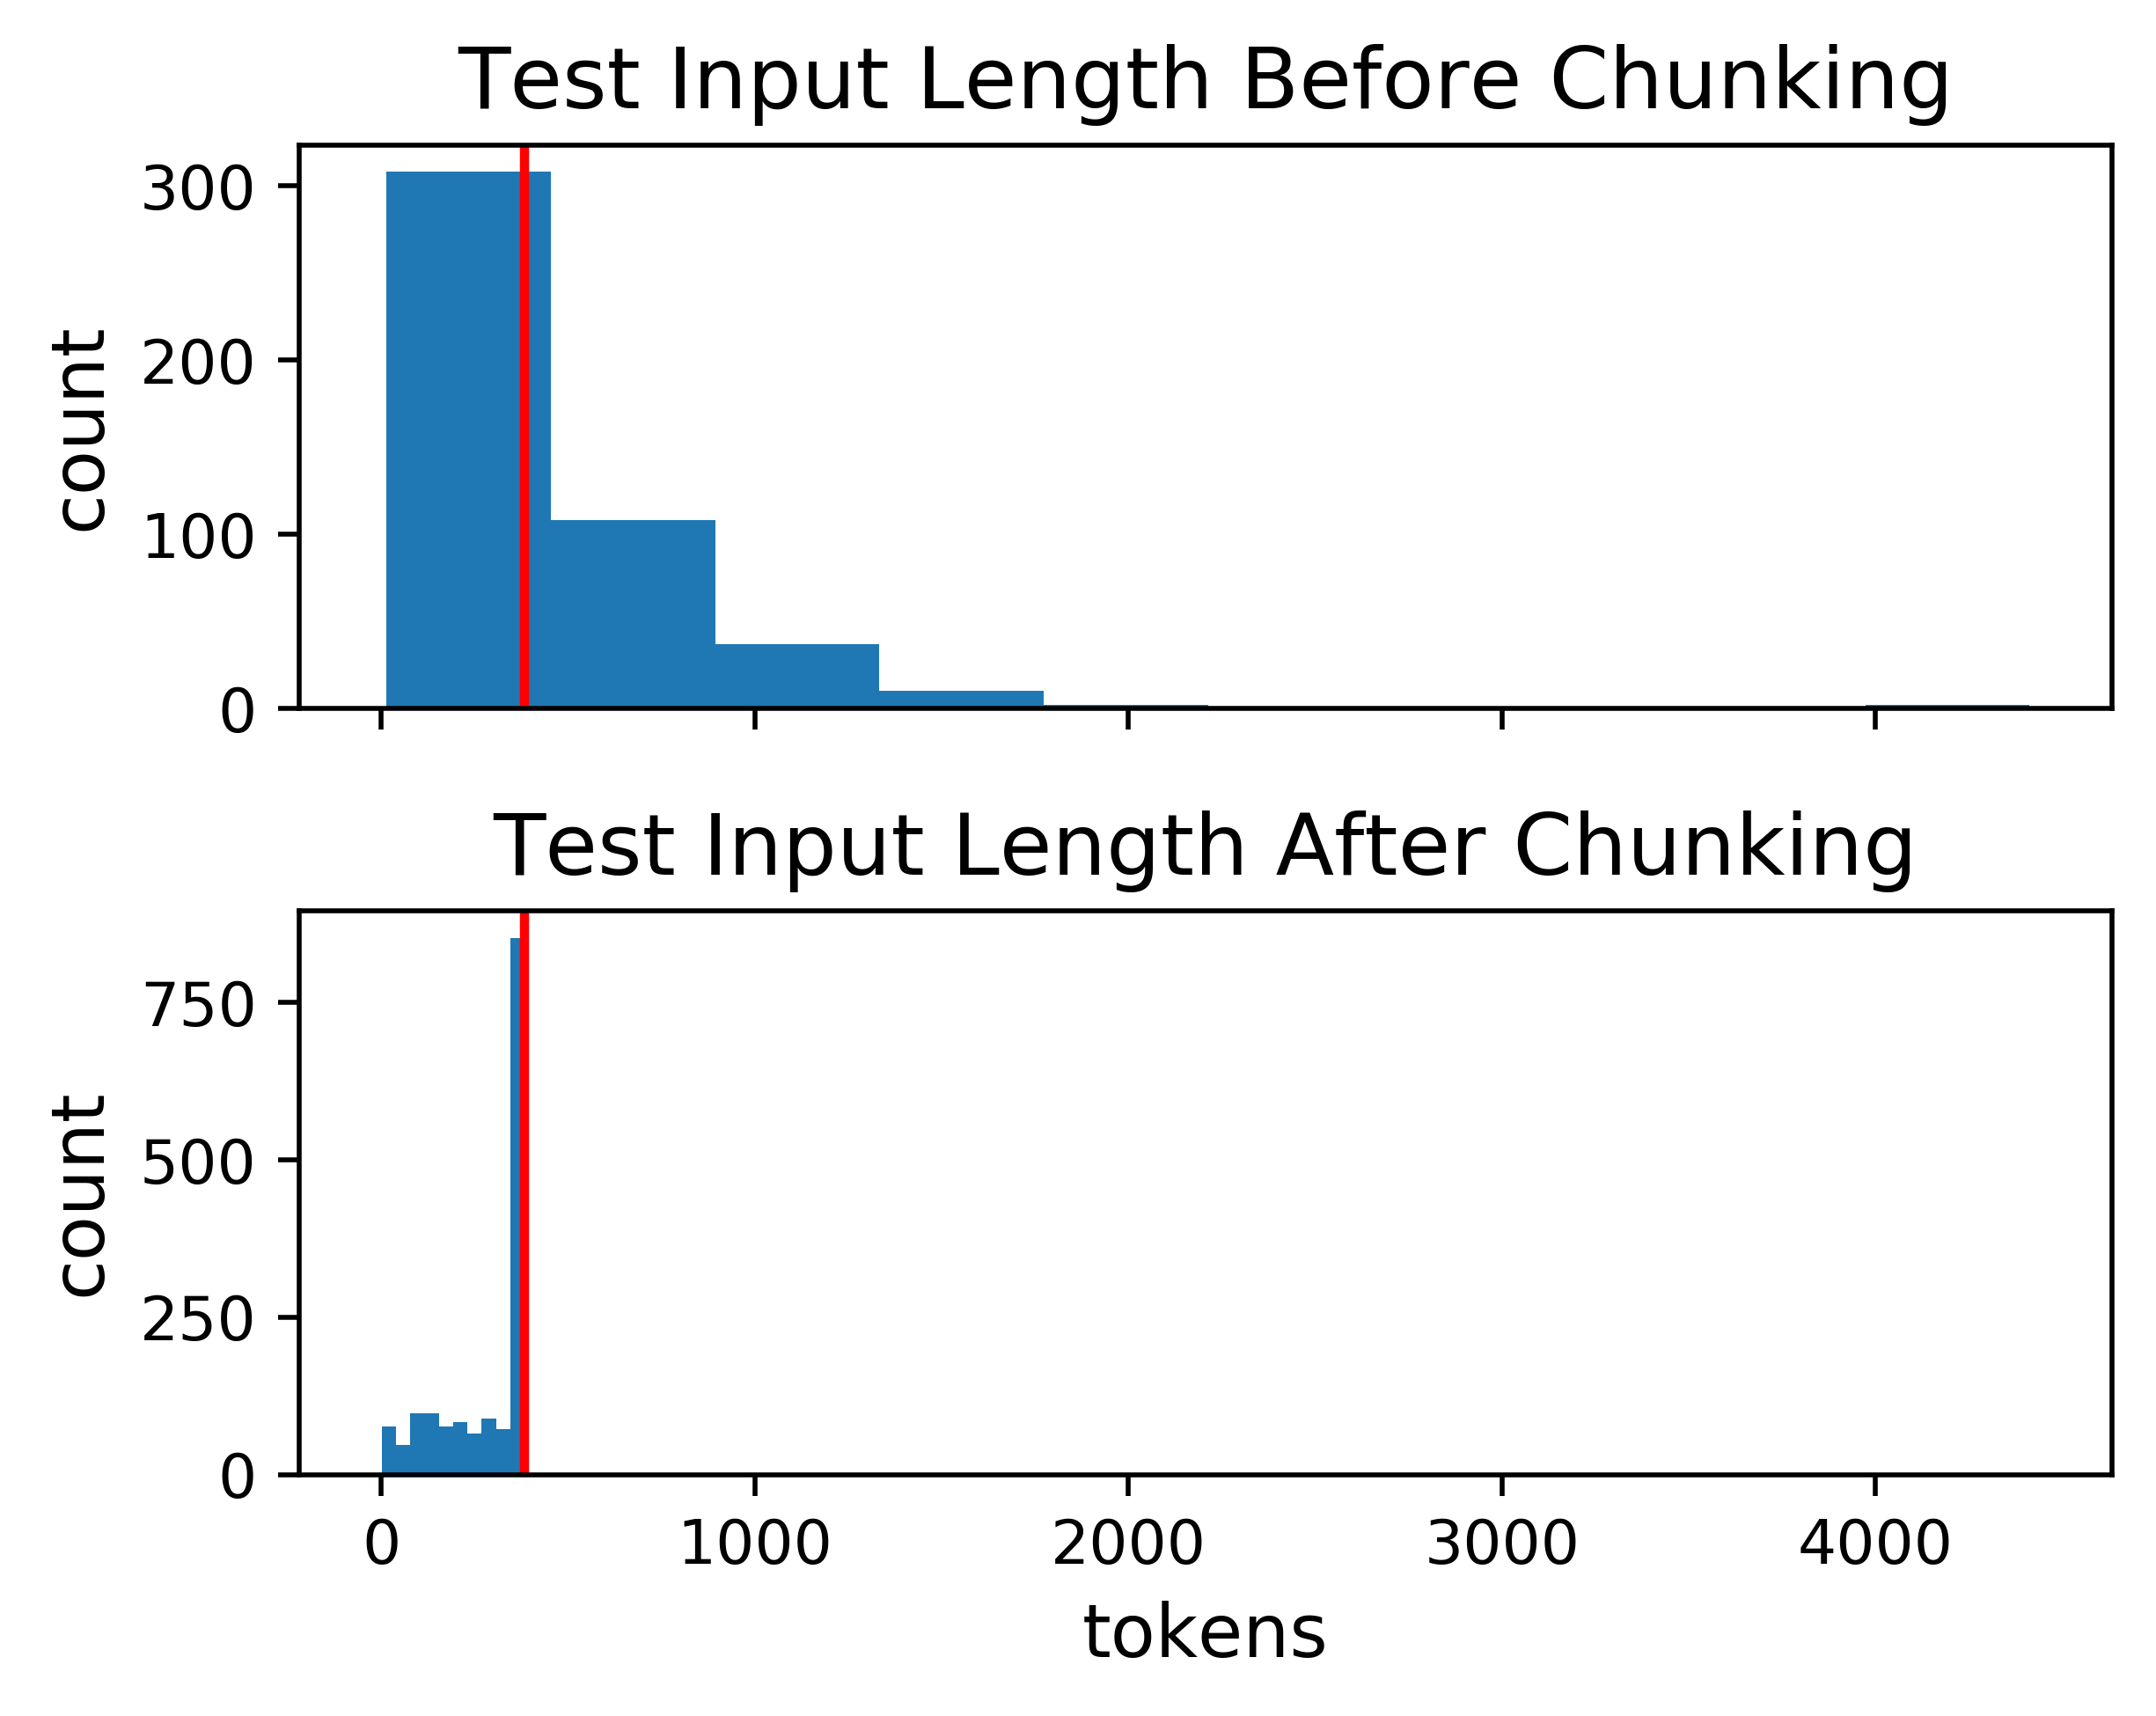

In [53]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[5, 4], sharex=True)
axs[0].hist(list(testDf["len1"]) + list(testDf["len2"]))
axs[0].axvline(384, color="red")
axs[0].set_title("Test Input Length Before Chunking", size=14)
axs[0].set_ylabel("count", size=12)
axs[1].hist(list(testChunked["len1"]) + list(testChunked["len2"]))
axs[1].axvline(384, color="red")
axs[1].set_title("Test Input Length After Chunking", size=14)
axs[1].set_ylabel("count", size=12)
axs[1].set_xlabel("tokens", size=12)
plt.tight_layout()

Text(0.5, 0, 'tokens')

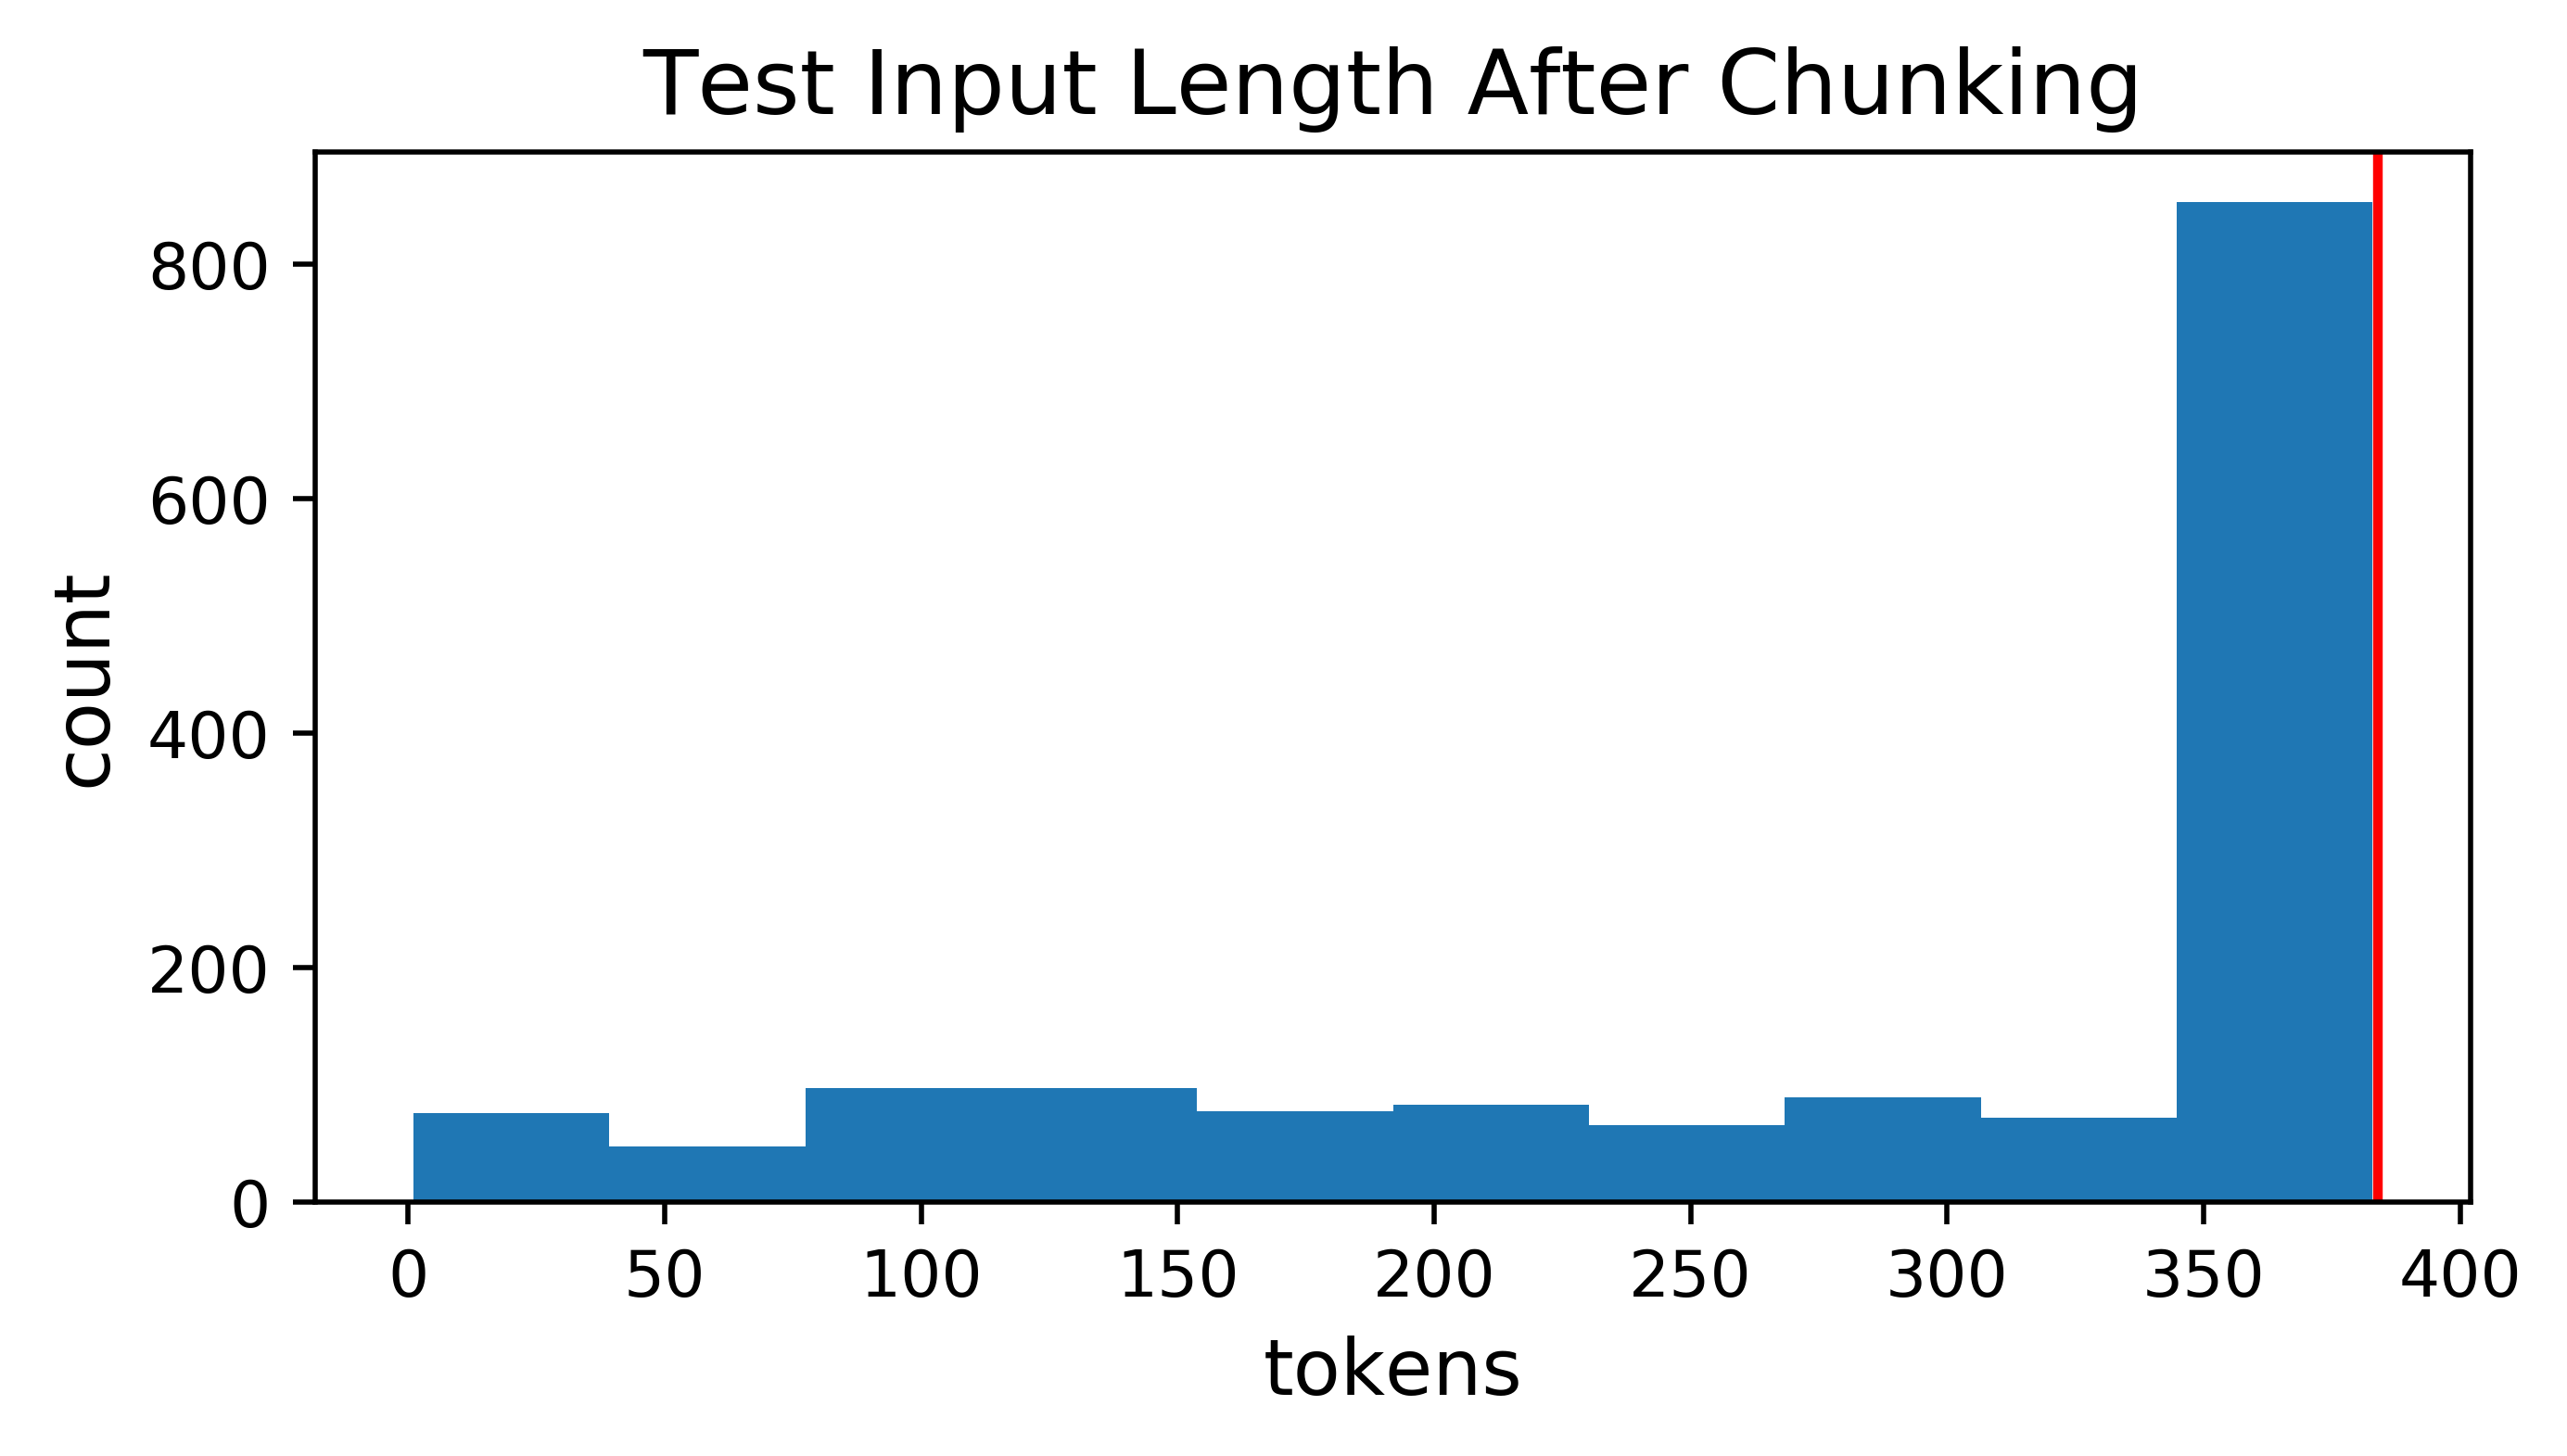

In [54]:
plt.subplots(figsize=[6, 3])
plt.hist(list(testChunked["len1"]) + list(testChunked["len2"]))
plt.axvline(384, color="red")
plt.title("Test Input Length After Chunking", size=14)
plt.ylabel("count", size=12)
plt.xlabel("tokens", size=12)

In [ ]:
testChunked

In [55]:
#load model
modelPath = "/home/blitt/projects/localNews/models/sentEmbeddings/0.2-mpNetCosSimTestChunked/output"
model = SentenceTransformer(modelPath)

#compute embeddings for the test data and get correlation with ground truth 
text1 = list(testChunked["text1"])
text2 = list(testChunked["text2"])

#embed test text 
embed1 = model.encode(text1)
embed2 = model.encode(text2)

#get our cosine sims 
cos_scores = [] 
for i in range(len(embed1)): 
    cos_scores.append(util.cos_sim(embed1[i], embed2[i]))
cos_scores[:2]

#rescale ground truth 
preds = [float(item) for item in cos_scores]
gt = (5 - testChunked["Overall"]) / 4
print(np.corrcoef([preds, gt]))

#to dataframe 
comparisonMat = pd.DataFrame({"gt":gt, "preds":preds})


[[1.         0.60474557]
 [0.60474557 1.        ]]


In [56]:
testChunked["gt"] = gt
testChunked["preds"] = preds

In [57]:
chunkingResults = testChunked.reset_index().groupby("index").agg(list)
chunkingResults["avgPred"] = chunkingResults["preds"].apply(np.mean)
chunkingResults["maxPred"] = chunkingResults["preds"].apply(max)
chunkingResults["minPred"] = chunkingResults["preds"].apply(min)
chunkingResults["medianPred"] = chunkingResults["preds"].apply(np.median)

In [58]:
chunkingResults["gt"] = chunkingResults["gt"].apply(lambda x: x[0])

In [59]:
for colName in ["avgPred", "maxPred", "minPred", "medianPred"]:
    print(colName)
    print(np.corrcoef([list(chunkingResults[colName]), chunkingResults["gt"]]))

avgPred
[[1.         0.71143669]
 [0.71143669 1.        ]]
maxPred
[[1.         0.74312361]
 [0.74312361 1.        ]]
minPred
[[1.         0.61772687]
 [0.61772687 1.        ]]
medianPred
[[1.         0.70879606]
 [0.70879606 1.        ]]


Text(0.5, 1.0, 'Max Similarity Aggregation')

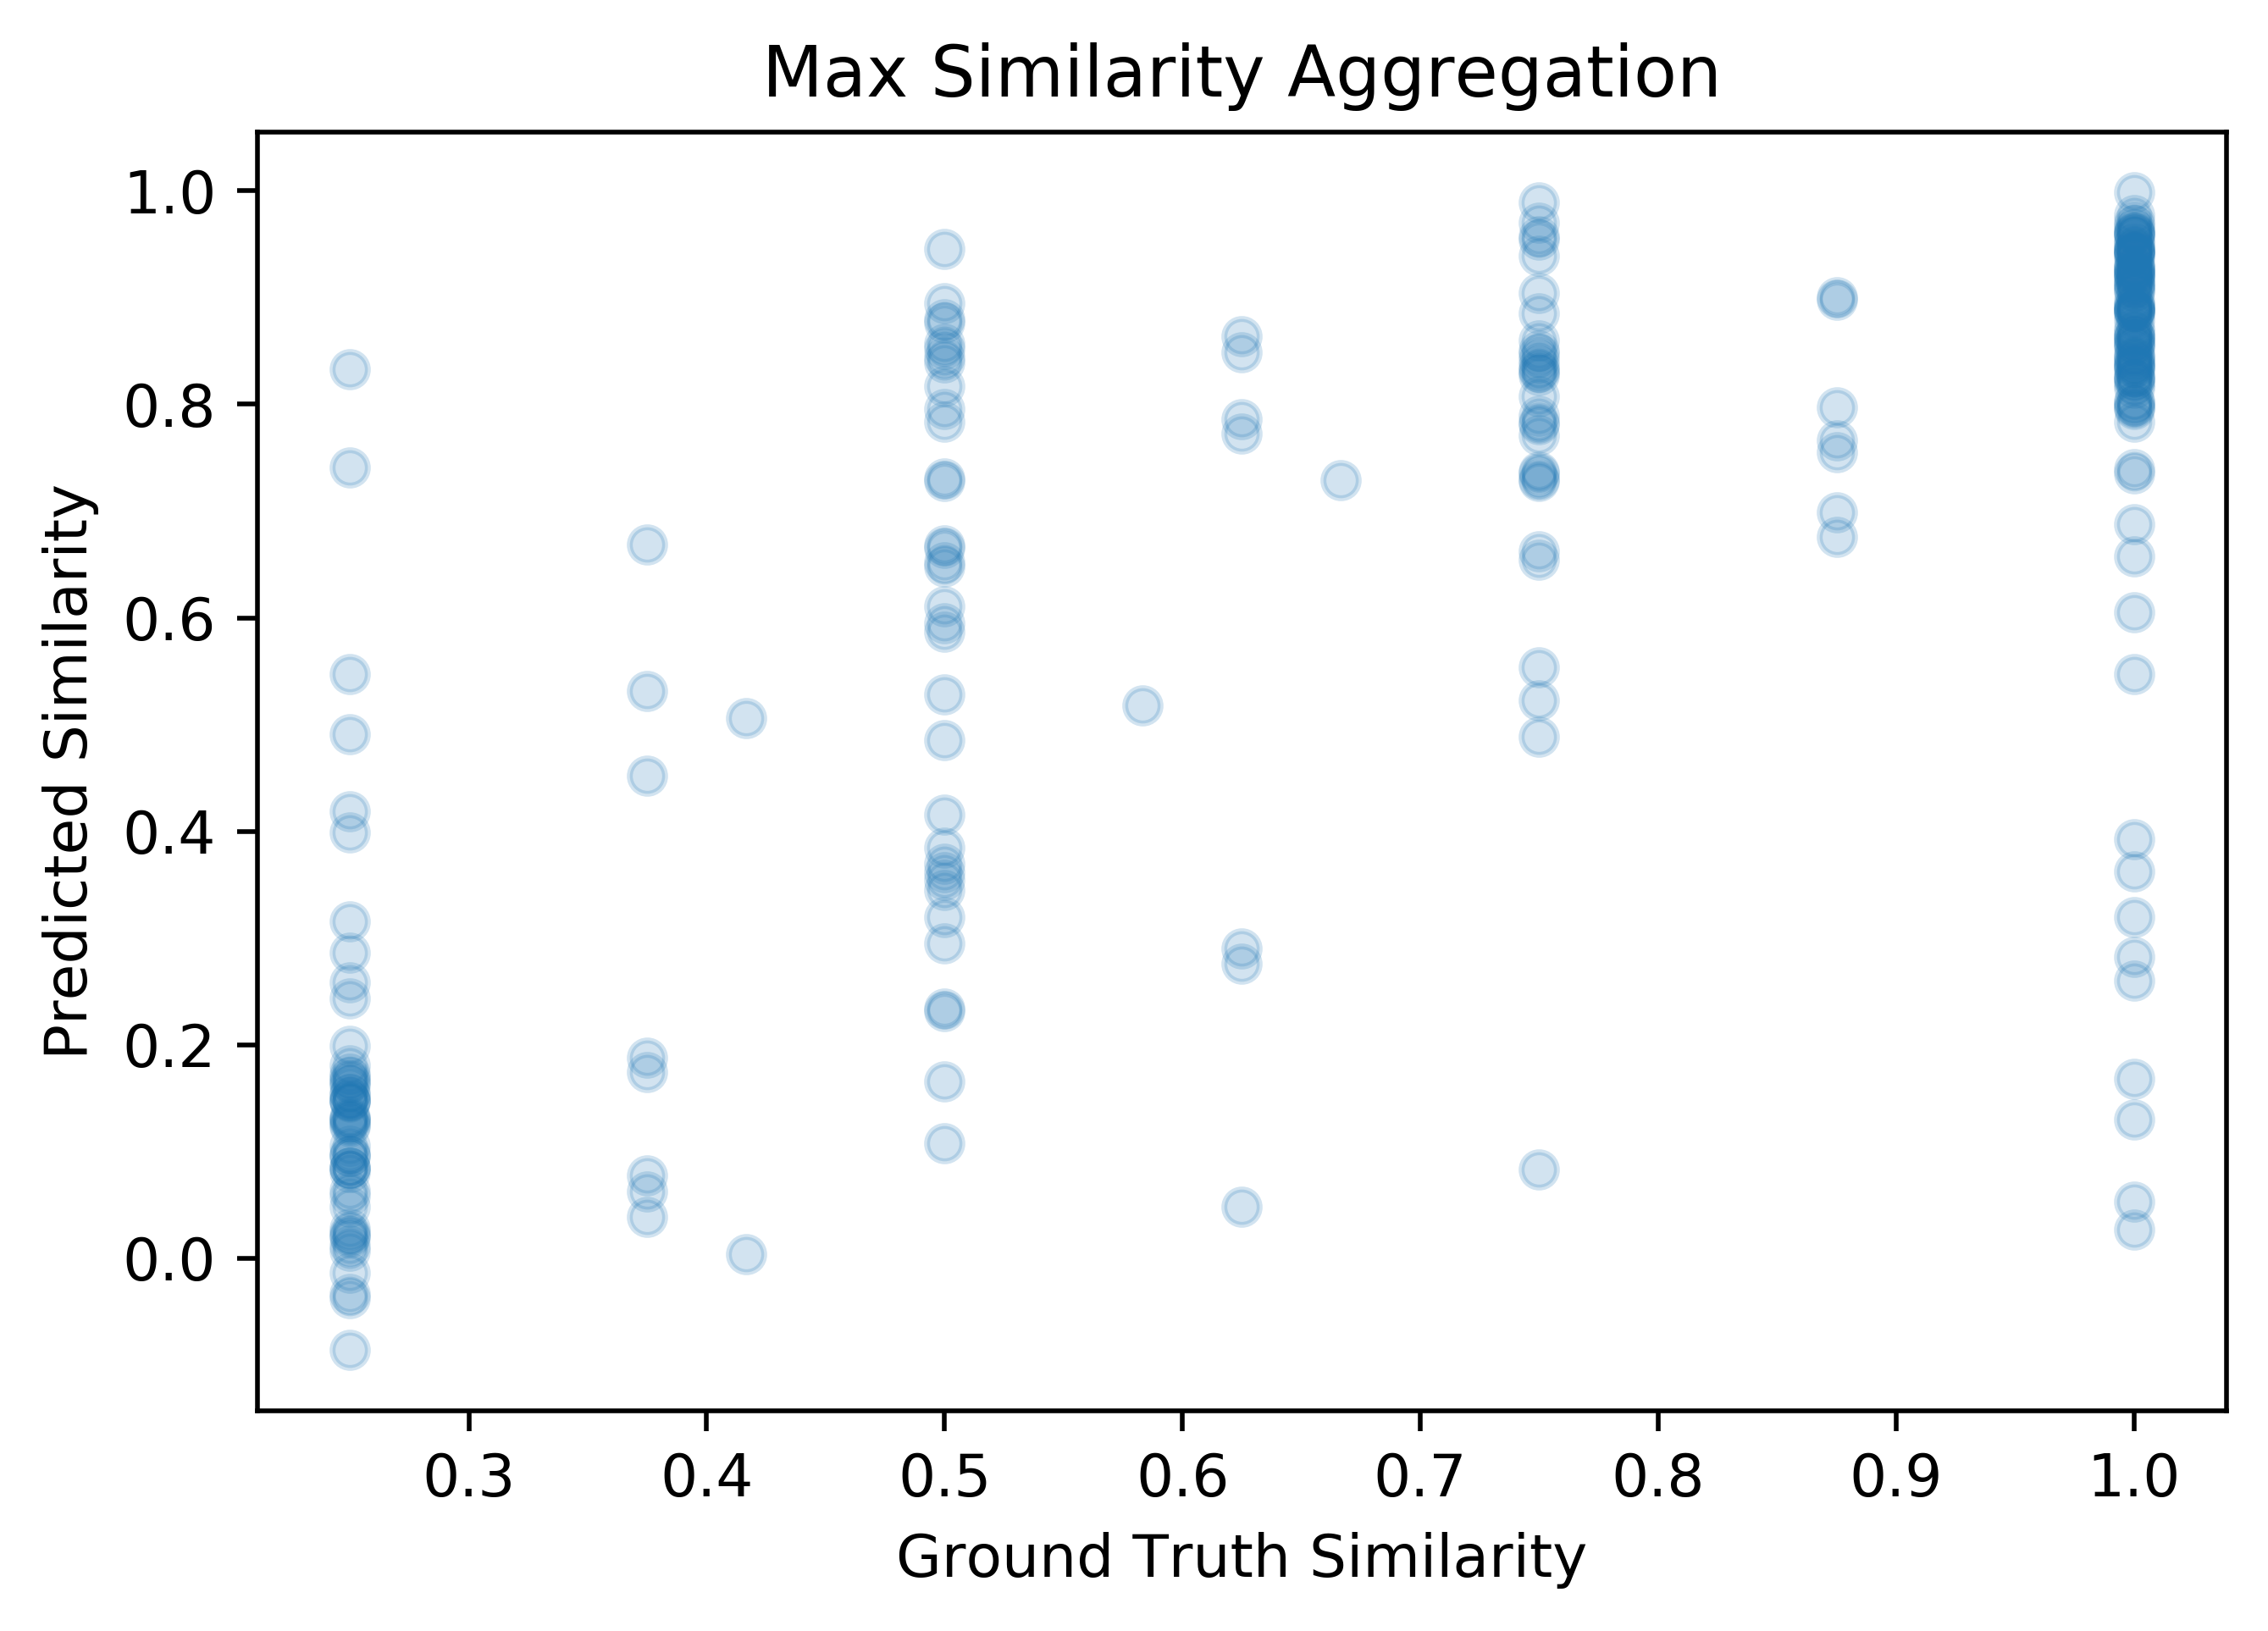

In [62]:
#compare ground truth on x axis to predictions on the y 
plt.scatter(chunkingResults["gt"], chunkingResults["maxPred"], alpha = .2)
plt.xlabel("Ground Truth Similarity")
plt.ylabel("Predicted Similarity")
plt.title("Max Similarity Aggregation")

In [61]:
chunkingResults.head(3)

,text1,text2,Overall,len1,len2,gt,preds,avgPred,maxPred,minPred,medianPred
index,,,,,,,,,,,
0,"[DAVIE, FLA. (WSVN) - Police need help catchin...","[DEERFIELD BEACH, FLA. (WSVN) - A no-swim advi...",[3.5],[97],[67],0.375,[0.03844425827264786],0.038444,0.038444,0.038444,0.038444
1,[Govt officials confirm Trump can block US com...,[The latest huge unsecured cloud storage find ...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","[376, 376, 376, 173, 173, 173]","[378, 370, 152, 378, 370, 152]",1.000,"[0.6169004440307617, 0.5549465417861938, 0.338...",0.495822,0.687707,0.265259,0.533125
2,"[Ducks defenseman Erik Gudbranson, left, knock...",[Woody Guthrie's 1943 New Year's Resolutions a...,"[4.0, 4.0, 4.0, 4.0]","[380, 382, 362, 280]","[93, 93, 93, 93]",0.250,"[-0.013427148573100567, 0.007309826090931892, ...",0.015484,0.048597,-0.013427,0.013383


In [ ]:
#conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])
bGt = [int(item) for item in chunkingResults["gt"] >= .8]
bPred = [int(item) for item in chunkingResults["maxPred"] >= .8]
precision, recall, fbeta, support = sklearn.metrics.precision_recall_fscore_support(bGt, bPred, average="binary")
print(precision)
print(recall)
print(fbeta)

In [ ]:
#create cutoff and get predictions/gt for binary classification problem 
cutoff = .6

comparisonMat["gtIsSame"] = comparisonMat["gt"] >= .8
comparisonMat["gtIsSame"] = comparisonMat["gtIsSame"].astype(int)

comparisonMat["predIsSame"] = comparisonMat["preds"] >= .8
comparisonMat["predIsSame"] = comparisonMat["predIsSame"].astype(int)
comparisonMat

In [ ]:
#TODO/NOTE: we can find cutoffs where precision and recall are very good. How do we think of a best value to pick..? 

In [ ]:
#confusion matrix 
conf = sklearn.metrics.confusion_matrix(comparisonMat["gtIsSame"], comparisonMat["predIsSame"])

#unpack conf matrix. Get accuracy 
acc = (conf[0,0] + conf[1, 1] ) / (len(comparisonMat))
tn, fp, fn, tp = conf.ravel()

#get precision, recall, f1
precision = (tp) / (tp + fp)
print("precision: " + str(precision))
recall = (tp) / (tp + fn)
print("recall: " + str(recall))
f1 = 2 * (precision * recall) / (precision + recall)
print("f1: " + str(f1))